<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/langchain/LangChain_Multi_modal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-modal RAG

Many documents contain a mixture of content types, including text and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:


### What we will be Using / Doing

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This notebook highlights `Option 3` from the image shown below.

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store raw text, tables and images along with their summaries for retrieval.

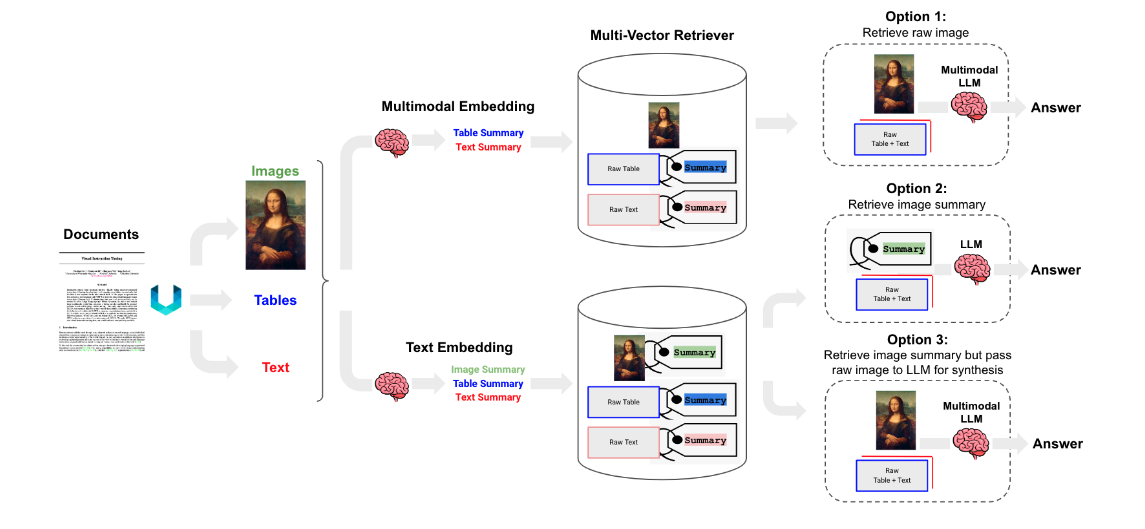

## SetUp

In [2]:
%%capture
!pip install "openai>=1" "langchain>=0.0.331rc2" "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken watermark

The PDF partitioning used by Unstructured will use:

- tesseract for Optical Character Recognition (OCR)
- poppler for PDF rendering and processing

Refer to poppler [installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html) and tesseract [installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html) in your system.

In [3]:
%%capture
!sudo apt-get install poppler-utils tesseract-ocr

In [4]:
%load_ext watermark
%watermark -a "Sudarshan Koirala" -vmp langchain,unstructured,openai

Author: Sudarshan Koirala

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

langchain   : 0.0.333
unstructured: 0.10.29
openai      : 1.2.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.120+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## Data Loading

### Partition PDF tables, text, and images
  
Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US.

We use Unstructured to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

In [5]:
import urllib.request

url = "https://sgp.fas.org/crs/misc/IF10244.pdf"
filename = "wildfire_stats.pdf"
urllib.request.urlretrieve(url, filename)

('wildfire_stats.pdf', <http.client.HTTPMessage at 0x7bbeae887580>)

In [6]:
path = "/content/"

In [7]:
from unstructured.partition.pdf import partition_pdf
# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=path + "wildfire_stats.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

In [9]:
len(tables), len(texts)

(2, 5)

In [10]:
tables[0]

'2018 2019 2020 2021 2022 Number of Fires (thousands) Federal 12.5 10.9 14.4 14.0 11.7 FS 5.6 5.3 6.7 6.2 5.9 DOI 7.0 5.3 7.6 7.6 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 50.5 59.0 59.0 69.0 Acres Burned (millions) Federal 4.6 3.1 7.1 5.2 4.0 FS 2.3 0.6 4.8 4.1 1.9 DOI 2.3 2.3 2.3 1.0 2.1 Other <0.1 <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 3.6 Total 8.8 4.7 10.1 7.1 7.6'

In [11]:
texts[0]

'a. aa = Informing the legislative debate since 1914 Congressional Research Service\n\nUpdated June 1, 2023\n\nWildfire Statistics\n\nWildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.\n\nFigure 1. Annual Wildfires and Acres Burned, 1993-2022\n\nAcres b

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

### Text and Table summaries

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [12]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [13]:
import openai
import os

# find API key in console at https://platform.openai.com/account/api-keys

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
openai.api_key = os.environ["OPENAI_API_KEY"]

# langsmith traces

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="YOUR_LANGCHAIN_API_KEY"
os.environ["LANGCHAIN_PROJECT"]="langchain-multimodal-pdf"

In [14]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [15]:
# Apply to text
# Typically this is reccomended only if you have large text chunks
text_summaries = texts # Skip it

# Apply to tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [16]:
len(table_summaries)

2

In [17]:
table_summaries[0]

'The table provides data on the number of fires and acres burned from 2018 to 2022. The fires are categorized into Federal, FS, DOI, Other, and Nonfederal. The total number of fires increased from 58.1 thousand in 2018 to 69.0 thousand in 2022. The number of acres burned peaked in 2020 at 10.1 million, but decreased to 7.6 million in 2022. Nonfederal fires and acres burned have generally been higher than those in the federal categories.'

In [18]:
table_summaries[1]

'The table presents data on the number of structures burned from 2019 to 2022 and the percentage of those structures that were residences. The number of structures burned peaked in 2020 at 17,904, with 54% being residences. In 2021, the number decreased to 5,972, but the percentage of residences increased to 60%. By 2022, the number of structures burned decreased further to 2,717, with residences making up 46% of the total.'

### Image summaries

We will use [GPT4-V](https://openai.com/research/gpt-4v-system-card) to produce the image summaries.

In [19]:
import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage

def encode_image(image_path):
    ''' Getting the base64 string '''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def image_summarize(img_base64,prompt):
    ''' Image summary '''
    chat = ChatOpenAI(model="gpt-4-vision-preview",
                      max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text":prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content

# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = "Describe the image in detail. Be specific about graphs, such as bar plots."

# Read images, encode to base64 strings
for img_file in sorted(os.listdir(path)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image,prompt))

In [20]:
len(img_base64_list)

5

In [21]:
img_base64_list[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiApQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1Pw74d0i78PWU89hDJK8eWYg5JzWp/wAIroX/AEDIPyNHhX/kVtO/65D+Zq/fahZ6bb/aL65it4c43ysFGfqaAKH/AAiuhf8AQMg/I0f8IroX/QMg/I1PY6/pGpO6WOpWtwyDcwilDYHqcVbtrqC8gWe2mSaJujocg0AZv/C

In [22]:
len(image_summaries) #we have five images

5

In [23]:
image_summaries[1]

'This image features a composite line and area graph showing data over time from the year 1993 to 2022. The graph is tracking two related metrics: the number of fires (in thousands) and the number of acres burned (in millions).\n\nOn the left vertical axis, we have the count of fires, marked as "Fires, thousands," with a scale that goes from 0 to 120, divided into increments of 20. The right vertical axis is labeled "Acres burned, millions," with a scale ranging from 0 to 12, also divided into increments of 2.\n\nThe number of fires is represented by the area graph, which is shaded in grey. It fluctuates over the years, with some peaks and troughs, generally staying between 40,000 and 100,000 fires.\n\nThe number of acres burned is represented by a red line graph, which has a generally upward trend over the 30-year period. It starts at a low point in 1993, dips and rises in the intervening years, and reaches a peak around 2015 before fluctuating in the later years, but still remaining 


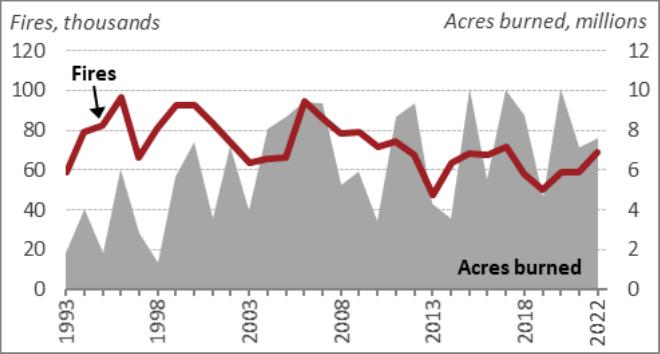

In [24]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

plt_img_base64(img_base64_list[1])

In [60]:
img_base64_list[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEABWQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo


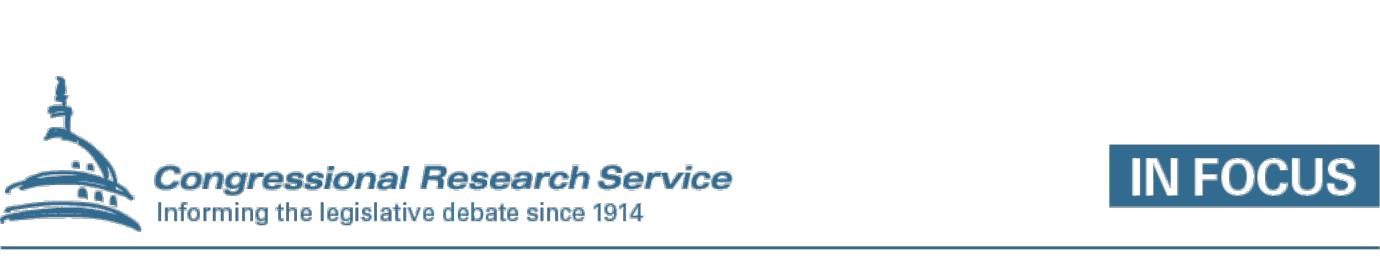

In [61]:
plt_img_base64(img_base64_list[0])

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

In [25]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

* Store the raw texts and tables in the `docstore`.
* Store the table summaries in the `vectorstore` for semantic retrieval.
* Use the tables in answer synthesis.

In [26]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

In [30]:
len(doc_ids), len(summary_texts)

(5, 5)

In [28]:
len(table_ids), len(summary_tables)

(2, 2)

* Store the images in the `docstore`.
* Store the image summaries in the `vectorstore` for semantic retrieval.
* Using the image in answer synthesis with a multimodal LLM.

In [31]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [32]:
len(img_ids), len(summary_img)

(5, 5)

In [55]:
summary_img[1]

Document(page_content='This image features a composite line and area graph showing data over time from the year 1993 to 2022. The graph is tracking two related metrics: the number of fires (in thousands) and the number of acres burned (in millions).\n\nOn the left vertical axis, we have the count of fires, marked as "Fires, thousands," with a scale that goes from 0 to 120, divided into increments of 20. The right vertical axis is labeled "Acres burned, millions," with a scale ranging from 0 to 12, also divided into increments of 2.\n\nThe number of fires is represented by the area graph, which is shaded in grey. It fluctuates over the years, with some peaks and troughs, generally staying between 40,000 and 100,000 fires.\n\nThe number of acres burned is represented by a red line graph, which has a generally upward trend over the 30-year period. It starts at a low point in 1993, dips and rises in the intervening years, and reaches a peak around 2015 before fluctuating in the later years

### Check retrieval

The mult-vector retriever will return base64-encoded images or text documents.

Confirm we can get images back based on natural language search.

Here is our retrieval of that table from the natural language query:

In [33]:
# Retrieve
docs = retriever.get_relevant_documents(
    "What is the change in wild fires from 1993 to 2022?"
)

In [34]:
len(docs)

4


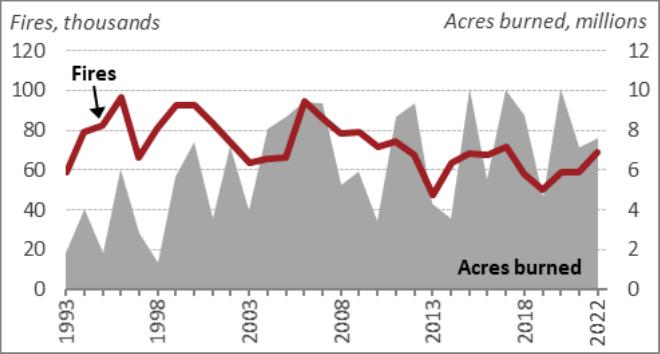

In [38]:
from base64 import b64decode
def split_image_text_types(docs):
    ''' Split base64-encoded images and texts '''
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }
docs_by_type = split_image_text_types(docs)
plt_img_base64(docs_by_type["images"][0])

In [48]:
len(docs_by_type["images"])

1

In [49]:
len(docs_by_type["texts"])

3

In [50]:
docs_by_type["texts"][0]

'2018 2019 2020 2021 2022 Number of Fires (thousands) Federal 12.5 10.9 14.4 14.0 11.7 FS 5.6 5.3 6.7 6.2 5.9 DOI 7.0 5.3 7.6 7.6 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 50.5 59.0 59.0 69.0 Acres Burned (millions) Federal 4.6 3.1 7.1 5.2 4.0 FS 2.3 0.6 4.8 4.1 1.9 DOI 2.3 2.3 2.3 1.0 2.1 Other <0.1 <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 3.6 Total 8.8 4.7 10.1 7.1 7.6'

In [51]:
docs_by_type["texts"][1]

'a. aa = Informing the legislative debate since 1914 Congressional Research Service\n\nUpdated June 1, 2023\n\nWildfire Statistics\n\nWildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.\n\nFigure 1. Annual Wildfires and Acres Burned, 1993-2022\n\nAcres b

In [52]:
docs_by_type["texts"][2]

'Source: National Interagency Coordination Center (NICC) Wildland Fire Summary and Statistics annual reports. Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.\n\nYear Acres burned (millions) Number of Fires 2015 2020 2017 2006 2007\n\nSource: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.\n\nThe number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.\n\nMost wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage b

In this case, 1 image and 3 text documents is retrieved.

## RAG

We format the inputs using a `RunnableLambda`. For more info about Langchain Expression Language, visit this [link](https://python.langchain.com/docs/expression_language/)

Runnable follows the classic RAG flow:

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here)
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model.
* And finally we parse the output as a string.

In [53]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
Question: {dict["question"]}

Text and tables:
{format_texts}
"""},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [54]:
chain.invoke(
    "What is the change in wild fires from 1993 to 2022?"
)

'Based on the provided context and the graph in Figure 1, the change in wildfires from 1993 to 2022 shows a slight decrease in the number of fires but a general increase in the number of acres burned. The line graph indicates that the number of fires, which is represented by the red line, has fluctuated over the years but shows a slight downward trend from 1993 to 2022. The shaded area representing acres burned shows variability but an overall upward trend, indicating that while there may be fewer fires, the ones that do occur are covering more land on average. The text also supports this by stating that the number of annual wildfires has decreased slightly over the last 30 years, while the number of acres affected annually has generally increased.'

Here is the [trace](https://smith.langchain.com/public/e101b5bb-c17e-445b-b22d-aed01dd4cbfb/r) for the last one.